In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Library

In [2]:
cd /content/drive/MyDrive/Todays_Chatbot/Preprocessing

/content/drive/.shortcut-targets-by-id/1yQ-EFTAnZETmcDATUTjJGzUXrx_KmHG_/Todays_Chatbot/Preprocessing


In [3]:
# !git clone https://github.com/ssut/py-hanspell.git

In [4]:
cd py-hanspell

/content/drive/.shortcut-targets-by-id/1yQ-EFTAnZETmcDATUTjJGzUXrx_KmHG_/Todays_Chatbot/Preprocessing/py-hanspell


In [5]:
# 수정한 hanspell 불러오기
from hanspell import spell_checker
from hanspell.constants import CheckResult

In [6]:
cd ..

/content/drive/.shortcut-targets-by-id/1yQ-EFTAnZETmcDATUTjJGzUXrx_KmHG_/Todays_Chatbot/Preprocessing


In [7]:
!pip install kss

     |████████████████████████████████| 71kB 4.2MB/s 


In [8]:
import numpy as np
import pandas as pd
import kss
import re
from tqdm.notebook import tqdm
from hanspell import spell_checker
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Load Data

In [9]:
df_path = '/content/drive/MyDrive/Todays_Chatbot/Crawling/data'
df = pd.read_csv(df_path+'/question_table.csv')

In [ ]:
df[:5]

,product_id,product_name,product_option,user_id,user_buyer,is_secret,label,question,question_time,answer,answer_time
0,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3080121,False,False,상품,어떤 유리인가요?,2021-03-19T01:16:01.000+09:00,None,None
1,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 화이트,3079369,True,False,배송,배송상태가 배송완료로되어있는데 아직상품이안왔습니다. 언제쯤도착하는지 확인부탁드릴게요.,2021-03-18T22:31:54.000+09:00,None,None
2,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 블랙,3078560,True,False,교환,상부 유리의 모서리가 다 깨져있습니다...재배송 부탁드려요,2021-03-18T20:13:11.000+09:00,None,None
3,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3077236,True,False,환불,상부 연결 목재 중 하나가 나사산이 덜 파져 있네요;; 조립하다 목재가 갈라져버립니...,2021-03-18T16:52:34.000+09:00,안녕하세요 고객님 먼데이하우스입니다.\r\n불편을 드려 죄송합니다.\r\n유선상 연...,2021-03-18T18:19:46.000+09:00
4,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3076525,True,False,상품,배송 언제 되는걸까요...?,2021-03-18T15:31:16.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n유선상 연락 및 안내드렸습니다.\r\n...,2021-03-18T15:52:19.000+09:00


### 비밀글 & 답변 없음 개수 확인

In [ ]:
# 전체 개수
df.shape

(125543, 11)

In [ ]:
# 비밀글
df[df['question']=='비밀글입니다.'].shape

(30203, 11)

In [ ]:
# 비밀글
df[df['answer']=='비밀글입니다.'].shape

(30188, 11)

In [ ]:
# 비밀글
df[df['is_secret']==True].shape

(30203, 11)

In [ ]:
# 그 외에는 비밀글 - None인 경우
df[(df['question']=='비밀글입니다.')&(df['answer']!='비밀글입니다.')]

,product_id,product_name,product_option,user_id,user_buyer,is_secret,label,question,question_time,answer,answer_time
822,379255,순수원목 선반장 4colors (가로2단),NaN,3081162,True,True,배송,비밀글입니다.,2021-03-19T10:04:15.000+09:00,None,None
826,379255,순수원목 선반장 4colors (가로2단),NaN,3079846,True,True,배송,비밀글입니다.,2021-03-19T00:00:14.000+09:00,None,None
827,379255,순수원목 선반장 4colors (가로2단),NaN,3079643,True,True,교환,비밀글입니다.,2021-03-18T23:19:03.000+09:00,None,None
23196,48328,카페 방수패브릭 접이식 소파베드 5colors,NaN,3078631,False,True,배송,비밀글입니다.,2021-03-18T20:25:40.000+09:00,None,None
29911,125056,침대 프레임 원목깔판 매트리스 받침대 7size,NaN,3079842,False,True,기타,비밀글입니다.,2021-03-18T23:59:31.000+09:00,None,None
29912,125056,침대 프레임 원목깔판 매트리스 받침대 7size,NaN,3079246,True,True,배송,비밀글입니다.,2021-03-18T22:11:41.000+09:00,None,None
59703,146362,모던 라운드 리빙박스 시리즈,NaN,3081222,True,True,배송,비밀글입니다.,2021-03-19T10:12:16.000+09:00,None,None
64025,159676,마스트 정품 스프레이 밀대청소기 물걸레,NaN,3081877,False,True,기타,비밀글입니다.,2021-03-19T11:38:50.000+09:00,None,None
64026,159676,마스트 정품 스프레이 밀대청소기 물걸레,NaN,3081570,True,True,반품,비밀글입니다.,2021-03-19T10:59:44.000+09:00,None,None
72608,115782,Q10 무선진공 청소기,NaN,3077561,True,True,기타,비밀글입니다.,2021-03-18T17:26:50.000+09:00,None,None


In [ ]:
# 답변 없음
df[df['answer']=='None'].shape

(50, 11)

### 비밀글 & 답변없음 제거

In [10]:
df = df[df['answer']!='None']
df = df[df['is_secret']==False]

In [11]:
df.shape # 40,000개 없어짐

(95305, 11)

In [ ]:
# 이미 저장 완료
# df.to_csv('data/question_table_drop.csv', index=False)

### 내용 중복 확인 (수정 필요, 아직 처리 X)

In [ ]:
len(df['question'].unique())
# 신기한데 얘도 줄어듬

92984

In [ ]:
len(df['answer'].unique())

80645

In [ ]:
t = df[['question','answer']].value_counts()

In [ ]:
p = t[t.values>1]

In [ ]:
p[:10]

question                                                                                                                                                        answer                                                                                                                                                                                                                                                                                                              
배송주소 변경하고 싶은데요 가능한가요                                                                                                                                            " ♡ 고객님 쇼핑에 기쁨을 드리는 SHEZHOME ♡ " \r\n안녕하세요, 고객님. 쉬즈홈입니다.\r\n저희 쉬즈홈 상품에 관심가져 주셔서 대단히 감사합니다.\r\n\r\n유선상으로 안내도와드렸습니다.\r\n\r\n다른 궁금한사항 있으신경우 업체 고객센터 또는 본공간Q&A으로 문의주시면 빠른안내 도와드리겠습니다.\r\n언제나 건강 유의하시고 즐거운일만 가득하세요:)                                                                                                         8
안녕하세요 저희가 2월15일에 이사라 그 때 배송 받고 싶은데요 지정일 배송이 되나요???       

In [ ]:
t1 = df.value_counts()
p1 = t1[t1.values>1]

In [ ]:
len(t1)

41318

In [ ]:
k = pd.DataFrame(df.value_counts().reset_index())
tmp = pd.merge(df, k)

In [ ]:
tmp[tmp[0]>1]['product_name'].unique()

array([], dtype=object)

In [ ]:
tmp[0].unique()

array([1])

In [ ]:
tmp[tmp[0]>1][-100:]

,product_id,product_name,product_option,user_id,user_buyer,is_secret,label,question,question_time,answer,answer_time,0


In [ ]:
len(p1)

0

In [ ]:
p1[:10]

Series([], dtype: int64)

In [ ]:
df.to_csv('./data/qna_table.csv', index=False)

## 전처리

In [ ]:
# file_path = '/content/drive/MyDrive/Todays_Chatbot/Preprocessing/data'
# df = pd.read_csv(file_path + '/question_table_drop.csv')

In [12]:
que = df['question'].to_numpy()
ans = df['answer'].to_numpy()

In [13]:
que.shape, que

((95305,),
 array(['상부 연결 목재 중 하나가 나사산이 덜 파져 있네요;; 조립하다 목재가 갈라져버립니다;;; 나사가 잘못된 각도로 들어간 것도 아니고...\n나사산이 덜 파져서 나사가 2/3 정도밖에 안 들어갔는데 더 안 들어가지다가 목재가 갈라져버렸어요.\n환불 요청드립니다..',
        '배송 언제 되는걸까요...?',
        '구매 하였는데 배송 메모는 무시해주세요ㅠ 다른곳에서 산거 수정을 못했어요ㅠㅠ 빠른배송 부탁드립니다!!', ...,
        '1.  이거  결제 하면  더 이상의 비용은 없나요?\n예를 들면  철거비나 쓰레기 처리 비용같은.......\n\n2.경기도  파주시 문발동입니다. 시공가능한가요?\n',
        '상품만 사면 시공도 다무료인가요?\n가게변기 교체좀하려구 하는데요.지역은 인천 청천동\n변기는 좌변기(화변기)입니다',
        '상품가격만 나와있어서요...설치기사님  비용은 어떻게되나요?지역은 경기도기흥입니다'], dtype=object))

In [14]:
ans.shape, ans

((95305,),
 array(['안녕하세요 고객님 먼데이하우스입니다.\r\n불편을 드려 죄송합니다.\r\n유선상 연락을 드렸으나 부재중이시네요..ㅠㅠ\r\n안타깝게도 조립을 시작하셨으면 반품이 어렵습니다.\r\n사이트내 하자사진과 함께 교환신청을 해주시면 하자인 부분만 재출고하고 있습니다.\r\n감사합니다.(3)\r\n',
        '안녕하세요 고객님~~먼데이하우스입니다.\r\n유선상 연락 및 안내드렸습니다.\r\n감사합니다.(1)',
        '안녕하세요 고객님~~먼데이하우스입니다.\r\n네 ~~주문확인되는데로 최대한 빠른 배송위해 최선을 다하겠습니다.\r\n감사합니다.(1)',
        ..., '수거비 철거비 포함입니다 시공 가능지역입니다', '네 맞습니다 ^^', '설치비용 포합입니다 ^^'],
       dtype=object))

### 한글&숫자만 남기고 제거

In [15]:
def text_cleaning(texts): # 수정완료
    # 한국어를 제외한 글자를 제거하는 패턴.
    corpus = []
    for i in range(0, len(texts)):
      sentences = re.sub("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]", " ", str(texts[i])) #특수문자를 제거하는 패턴
      sentences = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 |0-9|]", " ", sentences)
      sentences = re.compile('[|ㄱ-ㅎ|ㅏ-ㅣ]+').sub(' ', sentences) # 자음, 모음만 있는 경우

      sentences = re.sub(r"^\s+", '', sentences) #remove space from start
      sentences = re.sub(r'\s+$', '', sentences) #remove space from the end
      
      sentences = re.sub(r'\s+', ' ', sentences) #remove extra space

      corpus.append(sentences)
    return corpus

In [16]:
basic_preprocessed_question = text_cleaning(que)
basic_preprocessed_answer = text_cleaning(ans)

In [17]:
que = basic_preprocessed_question
ans = basic_preprocessed_answer

In [ ]:
que[:10]

['상부 연결 목재 중 하나가 나사산이 덜 파져 있네요 조립하다 목재가 갈라져버립니다 나사가 잘못된 각도로 들어간 것도 아니고 나사산이 덜 파져서 나사가 2 3 정도밖에 안 들어갔는데 더 안 들어가지다가 목재가 갈라져버렸어요 환불 요청드립니다',
 '배송 언제 되는걸까요',
 '구매 하였는데 배송 메모는 무시해주세요 다른곳에서 산거 수정을 못했어요 빠른배송 부탁드립니다',
 '조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요 육각 나사 렌치 보내주실수 있나요',
 '주문해서 다음주 월요일 3 22 에 받고싶은데 언제 주문하면될까요',
 '나사 너무 안들어가는데 원래 이렇게 나사가 안들어가나요 힘을 줘도 절대 끝까지 안들어갑니다',
 '배송이 안왔습니다 언제 배송될까요',
 '전화를 안받으시네요 유리끝부분이 다 잘린건 알겠는데 그중 하나가 살점이 더 나가있어요 포장만뜯고 조립도 아직 못한상태인데 빨리 유리 교환해 보내주세요 전화주십시오',
 '너무 쓰레기같아요 나사를끝까지돌려도 다 들어가지않고 다리가 덜렁거리고 나사 하나는 렌치로돌리는구멍이 막혀서 돌려넣을수도업고 아무리 저렴한제품이라도 이렇게 검수도 제대로안하고 판매하나요 고객센터는 전화도안받고 장난치는것도아니고 배송도 한오백년걸리는데 물건이따위로 보내주면 어떡하죠',
 '유리가 깨져서왔는데 유리만다시보내주세요 사진필요하시면첨부하겠습니다']

In [18]:
ans[:10]

['안녕하세요 고객님 먼데이하우스입니다 불편을 드려 죄송합니다 유선상 연락을 드렸으나 부재중이시네요 안타깝게도 조립을 시작하셨으면 반품이 어렵습니다 사이트내 하자사진과 함께 교환신청을 해주시면 하자인 부분만 재출고하고 있습니다 감사합니다 3',
 '안녕하세요 고객님 먼데이하우스입니다 유선상 연락 및 안내드렸습니다 감사합니다 1',
 '안녕하세요 고객님 먼데이하우스입니다 네 주문확인되는데로 최대한 빠른 배송위해 최선을 다하겠습니다 감사합니다 1',
 '안녕하세요 고객님 먼데이하우스입니다 따로 발송해드리도록 하겠습니다 감사합니다 1',
 '안녕하세요 고객님 먼데이하우스입니다 월요일 수령은 장담드리기 어렵습니다 주말 휴무이기때문데 금요일에 출고해드리면 토요일에 받을수 있어요 구매후 다음날정도 출고 진행하며 배송업체 스케줄에따라 1 3일정도 소요되는점 참고바랍니다 감사합니다 2',
 '안녕하세요 고객님 먼데이하우스입니다 저희 제품들이 원목 제품이라서 나사보다 구멍이 작게 뚤려 있답니다 사용하시면서 헐거워 지거나 하는 현상이 있어 작게 뚤려있는게 정상입니다 양쪽 기둥에 각각 선반을 끼워서 조립해 주시면 됩니다 이때 박스에 동봉되어 있는 나사와 기역자 모양의 렌치가 들어 있습니다 렌치중 짧은쪽을 나사홈에 끼우시고 긴쪽을 잡고 드라이버처럼 돌리시면 조립이 됩니다 면장갑을 끼고 손으로 먼저 조금 돌려서 고정 시킨후 조립하시면 됩니다 다시한번 조립 부탁드립니다 감사합니다 2',
 '안녕하세요 고객님 먼데이하우스입니다 고객님께서 구매시 지정일 28일 이후로 배송요청하셔서 29일 출고예정입니다 확인 부탁드립니다 감사합니다 2',
 '안녕하세요 고객님 먼데이하우스입니다 불편을 드려 죄송합니다 유선상 연락드렸습니다 감사합니다 3',
 '안녕하세요 고객님 먼데이하우스입니다 이용중 불편을 드려 죄송합니다 안타깝게도 구매하신 제품이 조립이 되어지면 반품이 불가하여 하자라고 생각되시는 부분의 사진을 첨부하여 오늘의집 고객센터로 교환접수 해주시면 담당부서에서 교환여부 확인후 진행도와드리겠습니

In [ ]:
# df에 업데이트
df['question_clean'] = que
df['answer_clean'] = ans

In [ ]:
# 이미 저장 완료
# df.to_csv('data/question_table_drop_clean.csv', index=False)

### maxlen 확인

In [ ]:
len_que=[]

for i in range(len(que)):
  #len_que.append(que[i])
  len_que.append(len(que[i]))

In [ ]:
min(len_que), max(len_que)

(0, 2224)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


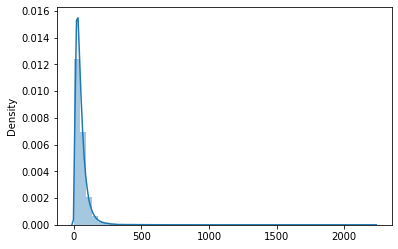

In [ ]:
import seaborn as sns
sns.distplot(len_que)

In [ ]:
len_ans=[]

for i in range(len(ans)):
  #len_que.append(que[i])
  len_ans.append(len(ans[i]))

In [ ]:
min(len_ans), max(len_ans)

(0, 1023)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


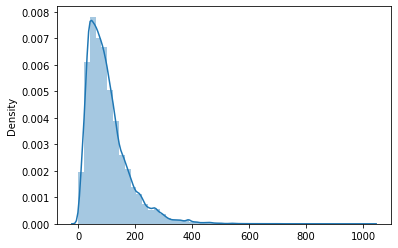

In [ ]:
import seaborn as sns
sns.distplot(len_ans)

In [ ]:
df_len_que=pd.DataFrame(len_que,columns=['len'])

In [ ]:
np.argmax(df_len_que)

38627

In [ ]:
que[38627]

'찍힌 자국과 스크래치가 있고 배송시킨 3개의 상품 모두에 약간씩의 흠이 있다고 애초에는 정상품에 해당한 지 문의를 오늘의 집 게시판 통해서 했더니 링크를 하나 만들어 줘서 링크 복사도 안되어서 손으로 하나 하나씩 치고 들어갔더니 사진을 올리라고 했습니다 단스탠드2개 장스탠드3개 구매를 했고 장스탠드 3개에 대한 당해 문의를 마켓비에서 요청하시는 대로 링크를 타고 마켓비 홈페이지에 사진 용량의 한계로 문의가 한 번에 이루어 지지 않아 사진을 게시하기 위해 글을 3번에 나눠서 문의글을 남겼더니 어이없게 다시 사진을 첨부하라는 답변이 달렸습니다 사진을 게시했다고 재문의를 넣았더니 파일명이 길어서 사진이 안 보일 수 있다고 합니다 시스템에 파일명으로 사진이 보이지 않는 것이 제 탓인가요 그래서 다시 사진을 첨부해서 문의글을 남기기를 여러번 물론 통화 연결을 시도했었는데 통화 연결이 되지 않아 계속 문의 글로 남겼습니다 그리고 구매한 지 한 열흘 지났나요 너무 오래되서 정확지 않은데 동일 건으로 하자가 아니라는 답변을 봐서 이게 이렇게 까지 어렵게 얻은 답이 도무지 모호해서 오늘의 집 통해서 우선 판매자에 대한 불만 신고 불량 신고를 하고 다시 한 번 누르고 마켓비로 전화를 해봤습니다 오늘 통화가 바로 됩니다 마켓비를 통해서 문의를 할 때 전화번호를 포함 신상을 적는 란이 있어 글은 기본 세팅된 대로 글을 비공개로 했는데 결국 담당자에게 전화 안내를 받지도 못하고 시간만 질질 끌리고 답변 모호한 답변 받고 상품 찝찝한 것 안고 있는 상태로 2주 가량 있다가 드디어 구매자 쪽에서 전화를 거니 통화가 된 겁니다 참 그 과정에 오늘의 집 통해 불만 신고를 할 때 마켓비 쪽으로 연결하려면 또 만 하루가 걸린다고 하더군요 그랬더니 기분 나쁘게 듣지 마라 건조하게 말한다고 오해하지 마라하더니 교환 안되니 필요하다면 오늘의 집 통해서 교환 요청하고 그것도 안되면 소비자보호원에 고발하라고 하더군요 그리고 나서 어떻게 고의인지 계속 문의를 받는 시스템부터 상담까지 계속 감정 상하게 

### hanspell 맞춤법

In [ ]:
# 오류 예시
def hanspell_(texts):
  spell_check = []
  for line in tqdm(texts[15028:15030]):
    print(line)
    spell = spell_checker.check(line).checked
    print(spell_checker.check(line))
    print(spell)
    spell_check.append(spell)
  
  return spell_check

spell_check_question = hanspell_(que)

집에 사람이없는데 착불 배송비를 어떻게 드려야할까요
Checked(result=True, original='집에 사람이없는데 착불 배송비를 어떻게 드려야할까요', checked='집에 사람이 없는데 착불 배송비를 어떻게 드려야 할까요', errors=2, words=OrderedDict([('집에', 0), ('사람이', 2), ('없는데', 2), ('착불', 0), ('배송비를', 0), ('어떻게', 0), ('드려야', 2), ('할까요', 2)]), time=0.2198479175567627)
집에 사람이 없는데 착불 배송비를 어떻게 드려야 할까요
제가 몇번 취소하다가 결정해서 두개 완료 햇는데 오늘 배송 가믕 한가요
Checked(result=True, original='제가 몇번 취소하다가 결정해서 두개 완료 햇는데 오늘 배송 가믕 한가요', checked='제가 몇 번 취소하다가 결정해서 두 개 완료했는데 오늘 배송 가믕 한가요', errors=4, words=OrderedDict([('제가', 0), ('몇', 2), ('번', 2), ('취소하다가', 0), ('결정해서', 0), ('두', 2), ('개', 2), ('완료했는데', 1), ('오늘', 0), ('배송', 0), ('가믕', 3), ('한가요', 0)]), time=0.21898150444030762)
제가 몇 번 취소하다가 결정해서 두 개 완료했는데 오늘 배송 가믕 한가요



In [ ]:
# df = pd.read_csv('data/question_table_drop_clean.csv')

In [ ]:
# df.columns

Index(['product_id', 'product_name', 'product_option', 'user_id', 'user_buyer',
       'is_secret', 'label', 'question', 'question_time', 'answer',
       'answer_time', 'question_clean', 'answer_clean'],
      dtype='object')

In [ ]:
# que = df['question_clean'].to_numpy()
# ans = df['answer_clean'].to_numpy()

In [19]:
# 파일 수정 후
def hanspell_(texts):
  spell_check = []
  for line in tqdm(texts):
    #print(line)
    spell = spell_checker.check(line).checked
    #print(spell_checker.check(line))
    #print(spell)
    spell_check.append(spell)
  
  return spell_check

In [ ]:
spell_check_question = hanspell_(que)

In [ ]:
df['question_spellcheck'] = spell_check_question

In [ ]:
df.to_csv('data/question_table_drop_clean_spellcheck_question.csv', index=False)

In [20]:
spell_check_answer = hanspell_(ans)

In [21]:
df['answer_spellcheck'] = spell_check_answer

In [22]:
df.to_csv('data/question_table_drop_clean_spellcheck_answer.csv', index=False)

### 파일 합치기

In [23]:
df = pd.read_csv('data/question_table_drop_clean_spellcheck_question.csv')
df1 = pd.read_csv('data/question_table_drop_clean_spellcheck_answer.csv')

In [24]:
df.shape, df1.shape

((95305, 14), (95305, 12))

In [25]:
df[:5]

,product_id,product_name,product_option,user_id,user_buyer,is_secret,label,question,question_time,answer,answer_time,question_clean,answer_clean,question_spellcheck
0,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3077236,True,False,환불,상부 연결 목재 중 하나가 나사산이 덜 파져 있네요;; 조립하다 목재가 갈라져버립니...,2021-03-18T16:52:34.000+09:00,안녕하세요 고객님 먼데이하우스입니다.\r\n불편을 드려 죄송합니다.\r\n유선상 연...,2021-03-18T18:19:46.000+09:00,상부 연결 목재 중 하나가 나사산이 덜 파져 있네요 조립하다 목재가 갈라져버립니다 ...,안녕하세요 고객님 먼데이하우스입니다 불편을 드려 죄송합니다 유선상 연락을 드렸으나 ...,상부 연결 목재 중 하나가 나사산이 덜 파죠 있네요 조립하다 목재가 갈라져버립니다 ...
1,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3076525,True,False,상품,배송 언제 되는걸까요...?,2021-03-18T15:31:16.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n유선상 연락 및 안내드렸습니다.\r\n...,2021-03-18T15:52:19.000+09:00,배송 언제 되는걸까요,안녕하세요 고객님 먼데이하우스입니다 유선상 연락 및 안내드렸습니다 감사합니다 1,배송 언제 되는 걸까요
2,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 화이트,3076317,True,False,배송,구매 하였는데 배송 메모는 무시해주세요ㅠ 다른곳에서 산거 수정을 못했어요ㅠㅠ 빠른배...,2021-03-18T15:05:32.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n네 ~~주문확인되는데로 최대한 빠른 배...,2021-03-18T16:08:01.000+09:00,구매 하였는데 배송 메모는 무시해주세요 다른곳에서 산거 수정을 못했어요 빠른배송 부...,안녕하세요 고객님 먼데이하우스입니다 네 주문확인되는데로 최대한 빠른 배송위해 최선을...,구매하였는데 배송 메모는 무시해주세요 다른 곳에서 산거 수정을 못했어요 빠른 배송 ...
3,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 블랙,3073853,True,False,상품,조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요.. 육각 나사 렌...,2021-03-18T10:23:56.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n따로 발송해드리도록 하겠습니다.\r\n...,2021-03-18T15:26:29.000+09:00,조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요 육각 나사 렌치 ...,안녕하세요 고객님 먼데이하우스입니다 따로 발송해드리도록 하겠습니다 감사합니다 1,조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요 육각 나사 렌치 ...
4,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3070524,False,False,배송,주문해서 다음주 월요일(3/22)에 받고싶은데..언제 주문하면될까요?,2021-03-17T19:50:58.000+09:00,안녕하세요 고객님 먼데이하우스입니다.\r\n월요일 수령은 장담드리기 어렵습니다.주말...,2021-03-18T16:45:11.000+09:00,주문해서 다음주 월요일 3 22 에 받고싶은데 언제 주문하면될까요,안녕하세요 고객님 먼데이하우스입니다 월요일 수령은 장담드리기 어렵습니다 주말 휴무이...,주문해서 다음 주 월요일 3 22에 받고 싶은데 언제 주문하면 될까요


In [26]:
df1[:5]

,product_id,product_name,product_option,user_id,user_buyer,is_secret,label,question,question_time,answer,answer_time,answer_spellcheck
0,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3077236,True,False,환불,상부 연결 목재 중 하나가 나사산이 덜 파져 있네요;; 조립하다 목재가 갈라져버립니...,2021-03-18T16:52:34.000+09:00,안녕하세요 고객님 먼데이하우스입니다.\r\n불편을 드려 죄송합니다.\r\n유선상 연...,2021-03-18T18:19:46.000+09:00,안녕하세요 고객님 먼데이 하우스입니다 불편을 드려 죄송합니다 유선상 연락을 드렸으나...
1,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3076525,True,False,상품,배송 언제 되는걸까요...?,2021-03-18T15:31:16.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n유선상 연락 및 안내드렸습니다.\r\n...,2021-03-18T15:52:19.000+09:00,안녕하세요 고객님 먼데이 하우스입니다 유선상 연락 및 안내드렸습니다 감사합니다 1
2,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 화이트,3076317,True,False,배송,구매 하였는데 배송 메모는 무시해주세요ㅠ 다른곳에서 산거 수정을 못했어요ㅠㅠ 빠른배...,2021-03-18T15:05:32.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n네 ~~주문확인되는데로 최대한 빠른 배...,2021-03-18T16:08:01.000+09:00,안녕하세요 고객님 먼데이 하우스입니다 네 주문 확인되는 데로 최대한 빠른 배송 위해...
3,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 블랙,3073853,True,False,상품,조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요.. 육각 나사 렌...,2021-03-18T10:23:56.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n따로 발송해드리도록 하겠습니다.\r\n...,2021-03-18T15:26:29.000+09:00,안녕하세요 고객님 먼데이 하우스입니다 따로 발송해드리도록 하겠습니다 감사합니다 1
4,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3070524,False,False,배송,주문해서 다음주 월요일(3/22)에 받고싶은데..언제 주문하면될까요?,2021-03-17T19:50:58.000+09:00,안녕하세요 고객님 먼데이하우스입니다.\r\n월요일 수령은 장담드리기 어렵습니다.주말...,2021-03-18T16:45:11.000+09:00,안녕하세요 고객님 먼데이 하우스입니다 월요일 수령은 장담 드리기 어렵습니다 주말 휴...


In [27]:
df_ = df.copy()

In [28]:
df_['answer_spellcheck'] = df1['answer_spellcheck']

In [30]:
df_[:5]

,product_id,product_name,product_option,user_id,user_buyer,is_secret,label,question,question_time,answer,answer_time,question_clean,answer_clean,question_spellcheck,answer_spellcheck
0,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3077236,True,False,환불,상부 연결 목재 중 하나가 나사산이 덜 파져 있네요;; 조립하다 목재가 갈라져버립니...,2021-03-18T16:52:34.000+09:00,안녕하세요 고객님 먼데이하우스입니다.\r\n불편을 드려 죄송합니다.\r\n유선상 연...,2021-03-18T18:19:46.000+09:00,상부 연결 목재 중 하나가 나사산이 덜 파져 있네요 조립하다 목재가 갈라져버립니다 ...,안녕하세요 고객님 먼데이하우스입니다 불편을 드려 죄송합니다 유선상 연락을 드렸으나 ...,상부 연결 목재 중 하나가 나사산이 덜 파죠 있네요 조립하다 목재가 갈라져버립니다 ...,안녕하세요 고객님 먼데이 하우스입니다 불편을 드려 죄송합니다 유선상 연락을 드렸으나...
1,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3076525,True,False,상품,배송 언제 되는걸까요...?,2021-03-18T15:31:16.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n유선상 연락 및 안내드렸습니다.\r\n...,2021-03-18T15:52:19.000+09:00,배송 언제 되는걸까요,안녕하세요 고객님 먼데이하우스입니다 유선상 연락 및 안내드렸습니다 감사합니다 1,배송 언제 되는 걸까요,안녕하세요 고객님 먼데이 하우스입니다 유선상 연락 및 안내드렸습니다 감사합니다 1
2,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 화이트,3076317,True,False,배송,구매 하였는데 배송 메모는 무시해주세요ㅠ 다른곳에서 산거 수정을 못했어요ㅠㅠ 빠른배...,2021-03-18T15:05:32.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n네 ~~주문확인되는데로 최대한 빠른 배...,2021-03-18T16:08:01.000+09:00,구매 하였는데 배송 메모는 무시해주세요 다른곳에서 산거 수정을 못했어요 빠른배송 부...,안녕하세요 고객님 먼데이하우스입니다 네 주문확인되는데로 최대한 빠른 배송위해 최선을...,구매하였는데 배송 메모는 무시해주세요 다른 곳에서 산거 수정을 못했어요 빠른 배송 ...,안녕하세요 고객님 먼데이 하우스입니다 네 주문 확인되는 데로 최대한 빠른 배송 위해...
3,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 블랙,3073853,True,False,상품,조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요.. 육각 나사 렌...,2021-03-18T10:23:56.000+09:00,안녕하세요 고객님~~먼데이하우스입니다.\r\n따로 발송해드리도록 하겠습니다.\r\n...,2021-03-18T15:26:29.000+09:00,조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요 육각 나사 렌치 ...,안녕하세요 고객님 먼데이하우스입니다 따로 발송해드리도록 하겠습니다 감사합니다 1,조립하다가 육각 나사 렌치 돌리는 부분이 다 갈려서 조립을 못해요 육각 나사 렌치 ...,안녕하세요 고객님 먼데이 하우스입니다 따로 발송해드리도록 하겠습니다 감사합니다 1
4,388715,순수원목 A사이드테이블 3colors,A사이드테이블 / 우드,3070524,False,False,배송,주문해서 다음주 월요일(3/22)에 받고싶은데..언제 주문하면될까요?,2021-03-17T19:50:58.000+09:00,안녕하세요 고객님 먼데이하우스입니다.\r\n월요일 수령은 장담드리기 어렵습니다.주말...,2021-03-18T16:45:11.000+09:00,주문해서 다음주 월요일 3 22 에 받고싶은데 언제 주문하면될까요,안녕하세요 고객님 먼데이하우스입니다 월요일 수령은 장담드리기 어렵습니다 주말 휴무이...,주문해서 다음 주 월요일 3 22에 받고 싶은데 언제 주문하면 될까요,안녕하세요 고객님 먼데이 하우스입니다 월요일 수령은 장담 드리기 어렵습니다 주말 휴...


In [31]:
df_.to_csv('data/question_table_drop_clean_spellcheck.csv', index=False)